In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,confusion_matrix,mean_squared_error
from xgboost import XGBClassifier
import shap

C:\Users\harizan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DF_VC = pd.read_csv('vehicle_claims_clean_labeled.csv')

In [3]:
#Step 1, cast 'Reg_year' to int
DF_VC['Reg_year'] = DF_VC['Reg_year'].apply(int)

#Step 2, cast 'Seat_num' to int
DF_VC['Seat_num'] = DF_VC['Seat_num'].apply(int)

#Step 3, cast 'Door_num' to int
DF_VC['Door_num'] = DF_VC['Door_num'].apply(int)

#Step 4, remove rows which have values outside 1 through 12 in 'Adv_month'
DF_VC = DF_VC[DF_VC['Adv_month'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]

#Step 5, remove rows which have negative values in the 'Runned_Miles', 'Price', 'repair_hours', 'repair_cost' columns
DF_VC = DF_VC[DF_VC['Runned_Miles'] >= 0]
DF_VC = DF_VC[DF_VC['Price'] >= 0]
DF_VC = DF_VC[DF_VC['repair_hours'] >= 0]
DF_VC = DF_VC[DF_VC['repair_cost'] >= 0]

#Step 6, rename weird column names
DF_VC.rename(columns = {' Genmodel':'Genmodel', ' Genmodel_ID':'Genmodel_ID'}, inplace = True)

#Step 7, remove rows which have illogical values for 'Reg_year'
DF_VC = DF_VC[~DF_VC['Reg_year'].isin([1900, 3010])]

#Step 9, remove rows with illogical engine sizes
DF_VC['Engin_size'] = DF_VC['Engin_size'].str[:-1]
DF_VC['Engin_size'] = DF_VC['Engin_size'].astype(float)

DF_VC = DF_VC[(DF_VC['Engin_size'] <= 6.9)]
DF_VC = DF_VC[(DF_VC['Engin_size'] >= 0.8)]

#Step 10, remove rows with 0 in 'Door_num' and biger then 5
DF_VC = DF_VC[DF_VC['Door_num'] != 0]
DF_VC = DF_VC[DF_VC['Door_num'] <= 5]


#Step 11,removing ungregular rows
DF_VC = DF_VC[DF_VC['Price'] < 3000000]
DF_VC = DF_VC[DF_VC['Seat_num'] > 1]
DF_VC = DF_VC[DF_VC['Seat_num'] < 8]
DF_VC = DF_VC[DF_VC['Runned_Miles'] < 6000000]
DF_VC = DF_VC[DF_VC['repair_cost'] < 140000]
DF_VC = DF_VC[DF_VC['repair_hours'] < 80]

#Step 12, removing rows for which "Reg_year" is later than "Adv_year"
DF_VC = DF_VC[DF_VC['Adv_year'] >= DF_VC['Reg_year']]

#Step 13, removing 


In [4]:
DF_VC.drop(columns=['Unnamed: 0','Genmodel_ID','issue_id','breakdown_date','repair_date'], inplace=True)

In [5]:
label_cols = ['Maker', 'Genmodel', 'Color', 'Bodytype','issue','Gearbox', 'Fuel_type']


In [6]:
LabelEncoder = LabelEncoder()

for col in label_cols:
    DF_VC[col] = LabelEncoder.fit_transform(DF_VC[col])

In [7]:
DF_VC['car_age'] = DF_VC['Adv_year'] - DF_VC['Reg_year']

In [8]:
DF_VC.drop(columns=['Color','Adv_day','Adv_year','Adv_month','Reg_year','category_anomaly'], inplace=True)

In [9]:
data = DF_VC[[col for col in DF_VC.columns if col != 'Label'] + ['Label']]

In [10]:
X = data.drop(columns=['Label'])
y = data['Label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
from imblearn.over_sampling import SMOTE 

In [13]:
sm = SMOTE(sampling_strategy = 'minority', random_state = 42)

X_train, y_train = sm.fit_resample(X_train, y_train)

In [14]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [15]:
# sk_scaler = MinMaxScaler()

# X_train = sk_scaler.fit_transform(X_train)

In [16]:
# f1 = f1_score(y_test, pred)
# auc = roc_auc_score(y_test, pred)
# print('f1_score:', f1)
# print('roc_auc_score:', auc)
# print('confusion_matrix:\n', confusion_matrix(y_test, pred))

In [18]:
data

,Maker,Genmodel,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,issue,repair_complexity,repair_cost,repair_hours,car_age,Label
0,5,132,14,60000,6.8,0,10,21500.0,5,4,9,3,395.000000,9.0,18,0
1,5,132,14,44000,6.8,0,10,28750.0,5,4,7,3,695.000000,6.0,16,0
2,5,132,14,55000,6.8,0,10,29999.0,5,4,10,3,89.999000,3.0,15,0
3,5,132,14,14000,6.8,0,10,34948.0,5,4,2,3,224.844000,6.0,15,0
4,5,132,14,61652,6.8,0,10,26555.0,5,4,14,3,75.933000,3.0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268245,63,683,6,140000,2.0,2,1,3185.0,5,5,0,3,183.700000,6.0,10,0
268246,63,683,6,158000,2.4,0,1,2990.0,5,5,3,3,1408.500000,48.0,11,0
268247,63,683,6,94000,2.4,0,1,4250.0,5,5,1,3,122.125000,6.0,9,0
268248,63,683,6,111000,2.4,0,10,2895.0,5,5,4,3,62.605500,3.0,14,0


In [23]:
model_xgb = XGBClassifier(n_estimators=1000,learning_rate=0.1,max_depth=7,subsample=0.7,min_child_weight=5 ,random_state=42)

model_xgb.fit(X_train, y_train)

pred_xgb = model_xgb.predict(X_test)

ac = accuracy_score(y_test, pred_xgb)

auc_xgb = roc_auc_score(y_test, pred_xgb)

f1_xgb = f1_score(y_test, pred_xgb,average='macro')
cm = confusion_matrix(y_test, pred_xgb)

print('accuracy:', ac)
print('f1_score:', f1_xgb)
print('roc_auc_score:', auc_xgb)
print('confusion_matrix:\n', cm)

accuracy: 0.919139511514878
f1_score: 0.7952686178095414
roc_auc_score: 0.7505338907799849
confusion_matrix:
 [[41375   748]
 [ 3195  3445]]


<Axes: >

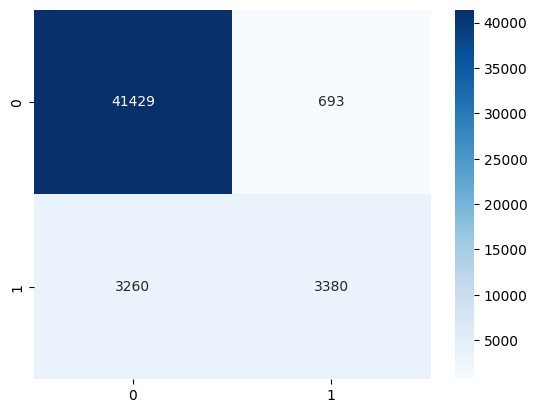

In [18]:
heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [19]:
explainer = shap.TreeExplainer(model_xgb)
explanation = explainer(X_train)

In [20]:
shap_values = explanation.values

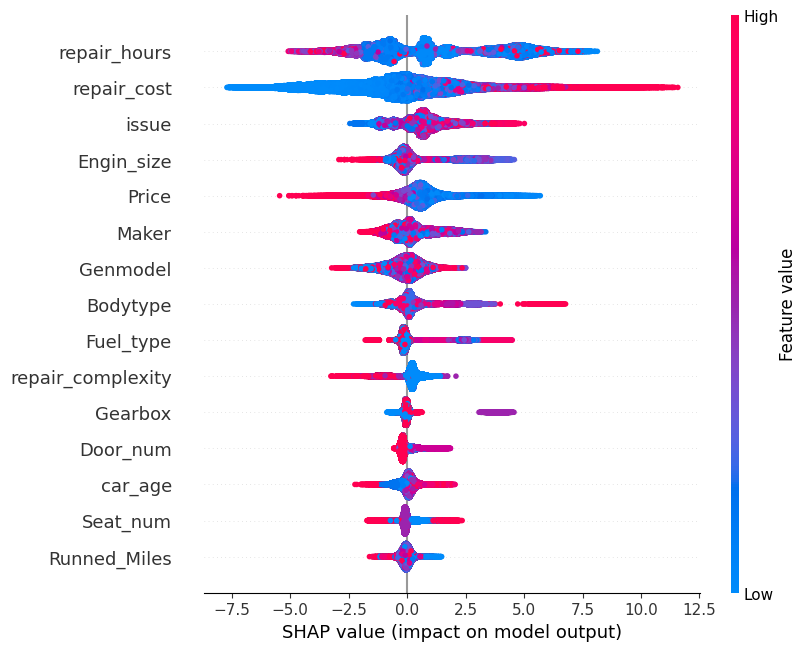

In [21]:
shap.plots.beeswarm(explanation, max_display=20)


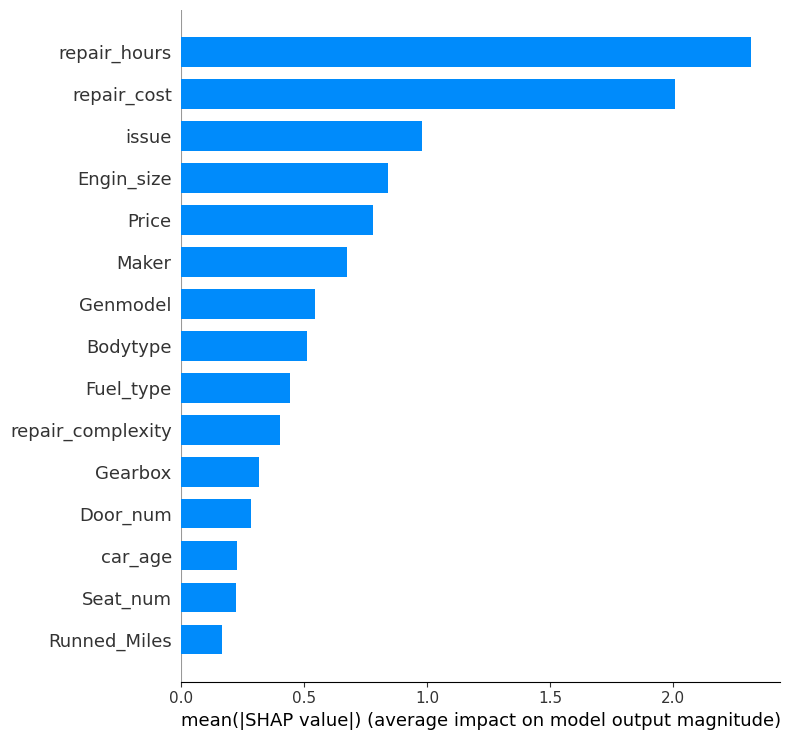

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar")
